In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
import pandas as pd
import xarray as xr
import geopy.distance
import matplotlib as mpl
import matplotlib.animation as animation

336


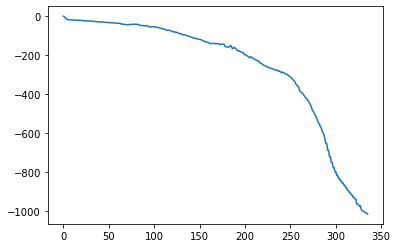

In [59]:
ds = xr.open_dataset('gebco_2023_n38.3_s38.2_w140.0_e142.369.nc')
depth = ds['elevation'][1,:]
depth = depth[depth.values < 0]
plt.plot(depth)
print(len(depth))
length = len(depth)

In [60]:
depth.lon[-1]

<xarray.DataArray 'lon' ()>
array(142.36875)
Coordinates:
    lat      float64 38.21
    lon      float64 142.4
Attributes:
    standard_name:       longitude
    long_name:           longitude
    units:               degrees_east
    axis:                X
    sdn_parameter_urn:   SDN:P01::ALONZZ01
    sdn_parameter_name:  Longitude east
    sdn_uom_urn:         SDN:P06::DEGE
    sdn_uom_name:        Degrees east

In [61]:
np.arange(0, 10, .1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])

In [62]:
from scipy import interpolate
f = interpolate.interp1d(depth.lon, depth)
lon_new = np.linspace(depth.lon[0], depth.lon[-1], len(depth.lon)*10)
depth_new = f(lon_new)
depth_new

array([-1.00000000e+00, -1.02515630e+00, -1.05031259e+00, ...,
       -1.01319500e+03, -1.01359750e+03, -1.01400000e+03])

In [63]:
coords_1 = (depth.lat, depth.lon[0])
coords_2 = (depth.lat, depth.lon[-1])
total_dist = geopy.distance.geodesic(coords_1, coords_2).m
dx = total_dist/len(depth_new)
print(dx, 'm')

36.710997414936045 m


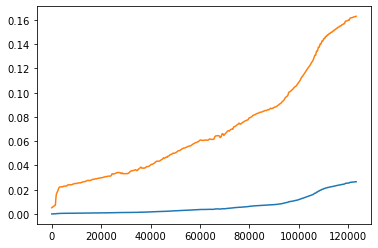

In [74]:
nx = len(depth_new)
#print(nx)
nt = 10000 

tf = 60*10

x = lon_new
x = np.array(x)
#print(x)
t = np.linspace(0,tf,nt)

dt = t[1]-t[0]

#changing wave speed
gravity = 9.81 #m/s
g = gravity

alpha = np.sqrt(abs(depth_new*g))
lam = alpha*dt/dx

x1 = np.arange(0,total_dist,dx)
plt.plot(x1, lam**2)
plt.plot(x1,lam)

In [77]:
u = np.nan*np.ones([nx,nt])

u[:,0] = np.exp(-(x1**2) / 2) #initializing first two time steps bc we have k-1
u[:,1] = np.exp(-(x1**2) / 2)

data = np.array([(lam**2)*np.ones(nx), 2*(1-lam**2)*np.ones(nx), (lam**2)*np.ones(nx)])
diags = np.array([-1, 0, 1])
M = spdiags(data, diags, nx, nx).toarray()

#Reflective BC
M[0,0] = 2-lam[0]**2
M[-1,-1] = 2-lam[-1]**2

#Radiating
M[0,0] = 0
M[-1,-1] = 0


for k in np.arange(nt-2):
    u[:,k+2] = np.matmul(M,u[:,k+1]) - u[:,k]


np.shape(u)

(3360, 10000)

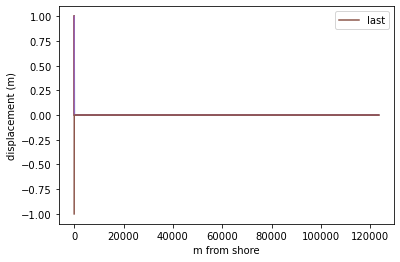

In [78]:
plt.plot(x1, u[:,0])
plt.plot(x1, u[:,1000])
plt.plot(x1, u[:,2500])
plt.plot(x1, u[:,5000])
plt.plot(x1, u[:,7500])
plt.plot(x1, u[:,-1],label='last')
plt.xlabel('m from shore')
plt.ylabel('displacement (m)')
plt.legend()
#print(u)

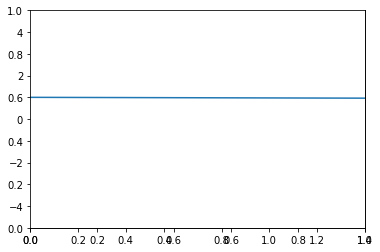

In [68]:
#not correct but progress
fig, ax = plt.subplots()
ax = plt.axes(xlim=(0, 1.4), ylim=(-5,5))
line = ax.plot(x1, u[:,0])[0]
def animate(i):
    line.set_ydata(u[:, i])
anim = animation.FuncAnimation(
    fig, animate, interval=20, frames=10000-1)
 
plt.draw()
plt.show()
#anim.save('wave_7.gif')

### 1D Propagation of a Tsunami towards the Coast of Japan

Nihal Velagapudi, Brooke Sciandra, Emily Melvin

### Introduction:

The theme of this project is the 1-dimensional propagation of a tsunami wave on the ocean created by an earthquake towards a coast. This topic is important because predicting the movement and intensity of tsunamis can help reduce deaths and injuries as well as associated destruction of land and developments.

This project focuses on modeling the 2011 Tohoku earthquake and tsunami that impacted Japan. It was the most powerful earthquake recorded in Japan. The waves of the tsunami reached heights of up to 40.5 meters. The tsunami waves traveled up to 10 kilometers inland. Residents on land only had about 8 to 10 minutes of warning.

### Equations

The equations used in this model included the wave equation. This equation describes how a wave moves through space and time.

$$\frac{\partial^2 ζ}{\partial t^2} - gH\frac{\partial^2 ζ}{\partial x^2} = 0 $$

ζ refers to the sea level changes, g is the gravitation constant (9.81 m/s^2), and H is the water depth.

To determine wave speed (α), the following equation was used:

$$α = \sqrt{gH} $$

$$λ = α\frac{dt}{dx}$$

### Numerical Methods

The centered difference scheme was used to solve the wave equation in this model. This is the typical method used to solve the wave equation.